# Full example

Here we will demonstrate how to make a risk assessment using hera.
The steps of a general risk assessments are the following:

<ol>
    <li>Loading data to the database</li>
    <li>Creating a case directory (for openFOAM runs)</li>
    <li>Arranging GIS data</li>
    <li>Running the root case (for openFOAM runs)</li>
    <li>Running the LSM simulation</li>
    <li>Finding evaporation rate (for continuous evaporation from pools)</li>
    <li>Getting the concentration</li>
    <li>Getting the population</li>
    <li>Choosing an agent</li>
    <li>Projection on population</li>
    <li>Presentation</li>
</ol>

Note that the LSM simulation may be made using two different systems, openFOAM or fortran code.
Some steps may be different for each system.

## Loading data to the database

Risk assessments require topography and demography data.
The specific data which is needed for a specific project may be cut from a general, wide data.
This data should be loaded to the database using hera-data.

The data is loaded to the database simply by running the "loadAll" file in the hera-data package.

## Creating a case directory

This step is needed only for openFOAM simulations.
In the future, these steps would be performed using hermes.

## Arranging GIS data

First, we have to choose an area of interest.
In the next example we choose an area near Haifa.
We define a rectangle and get its topography as a geopandas dataframe.

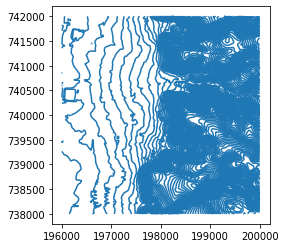

In [2]:
xmin = 196000
xmax = 200000
ymin = 738000
ymax = 742000
from hera.measurements.GIS.locations.topography import datalayer as topoDatalayer
topography = topoDatalayer(projectName="Topography", FilesDirectory="/home/eyal/Projects/2020/riskAssessments/haifaStable/rootCase/constant/triSurface", 
                           databaseNameList=None, useAll=False,publicProjectName="Topography",Source="BNTL")
tiratCarmel = topography.getDocuments(points=[xmin,ymin,xmax,ymax],CutName="tiratCarmel")[0].getData()
tiratCarmel.plot()

Then, we have to make a file in the appropiate format for the chosen LSM system.
For openFOAM, we have to build an STL file:

In [3]:
stlstring, data = topography.analysis.toSTL(data=tiratCarmel, NewFileName="caseE", save=True, addToDB=True)

> /home/eyal/Development/Hera/hera/measurements/GIS/locations/topography.py(174)toSTL()
-> stlstr = documents[0].getData()


(Pdb)  c


For fortran, we have to build a DEM string.

In [1]:
DEMstring = topography.analysis.getDEM(data=tiratCarmel)

NameError: name 'topography' is not defined

## Running the root case

This step is needed only for openFOAM simulations.

It will also be performed using hermes.

These are the commands that we run in the root case directory:

blockMesh

surfaceFeatureExtract

snappyHexMesh -overwrite

simpleFoam

## Running the LSM simulation

### openFOAM

After the mean velocity is calculated, we will copy the coverged 
state to two new time steps (in this example, the mean velocity is constant in time).
This copy will be handled in the future by hermes.

After the copy we will run the command cellCenters, and then we can run the next line,
in order to get the cell heights which are needed for the LSM simulation.

In [1]:
from hera.simulations.openfoam.lsm.preProcess import preProcess
preP = preProcess(projectName="tiratCarmal",casePath="/home/eyal/Projects/2020/riskAssessments/haifaStable/rootCase",cloudName="kinematicCloud")
preP.makeCellHeights(ground="caseE",times=[0,10000],savePandas=True,addToDB=True)

In addition, we need to assess the shear velocities at the cell centers:

In [1]:
preP.makeUstar(times=[0,10000],savePandas=False,addToDB=False)

Interpolated velocity near ground for another step
Interpolated velocity near ground for another step
Interpolated velocity near ground for another step
Interpolated velocity near ground for another step
Interpolated velocity near ground for another step
finished interpolations


/raid/opt/anaconda3/envs/Math-20-05/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2874: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/eyal/Development/Hera/hera/simulations/openFoam/utils.py:185: RuntimeWarning: invalid value encountered in log
  data["ustar"]=data["UnearGround"]*0.4/numpy.log(data["height"]/0.15)


wrote time  10000
Interpolated velocity near ground for another step
Interpolated velocity near ground for another step
Interpolated velocity near ground for another step
Interpolated velocity near ground for another step
Interpolated velocity near ground for another step
finished interpolations


/raid/opt/anaconda3/envs/Math-20-05/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2874: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)
/home/eyal/Development/Hera/hera/simulations/openFoam/utils.py:185: RuntimeWarning: invalid value encountered in log
  data["ustar"]=data["UnearGround"]*0.4/numpy.log(data["height"]/0.15)


wrote time  10000


Now we can induce particles to the system.

In the next example we will use a continuous point source.
The location of the source and the number of particles is set below:

In [1]:
from hera.simulations.openfoam.lsm.preProcess import preProcess
preP = preProcess(projectName="tiratCarmal",casePath="/home/eyal/Projects/2020/riskAssessments/haifaStable",cloudName="kinematicCloud")
x = 196500 #the source's x coordinate
y = 740500 #the source's y coordinate
z = 30 #the source's z coordinate
nParticles = 1000 #the number of particles induced every time step
#preP.makeSource(x=x,y=y,z=z,nParticles=nParticles,type="Point")

Finally, we run the simulation using the next command:

StochasticLagrangianSolver

### fortran

In order to use fortran code, templates must be loaded to the database.
If it is the first time one uses hera-lsm, two steps are required.
First, the makeFortranTemplates file in the fortran subdirectory of hera-lsm nust be run.
Then, the hera-LSM-load-template bin file should be run.
When running it, the template's name must be given.
Additional optional parameters are database and project name. For example:

**hera-LSM-load-template v1-general [DataBase name] [Project Name]**

Now we will demonstrate how to run the simulation.
The parameters defined in the parameters dictionary are the default parameters,
except for the topography file.
The topography parameter in the run function is optional;
if it is not defined the simulation is performed over a flat terrain.
We pass the DEM string of the topography.

When using topography, wind measurements must be given.
These measurements include wind velocity and direction for any number of measurements stations in different times.
Each station must have a name and x/y coordinates.
The measurements should be given as dataframes of the following format (the 'measurements' here are made-up values):

In [5]:
import pandas

flatAreaX = 197000
mountainAreaX = 199000
Y = 740000
flatVelocity = 2
flatDirection = 0
mountVelocity = 3
mountDirection = 45
stations = pandas.DataFrame({"station":["flat","flat","mount","mount"],"x":[flatAreaX,flatAreaX,mountainAreaX,mountainAreaX],
                             "y":Y,"u":[flatVelocity,flatVelocity,mountVelocity,mountVelocity],
                             "direction":[flatDirection,flatDirection,mountDirection,mountDirection],
                             "datetime":[pandas.Timestamp('2021-01-01 00:00:00'), pandas.Timestamp('2021-01-01 02:00:00'),
                                         pandas.Timestamp('2021-01-01 00:00:00'), pandas.Timestamp('2021-01-01 02:00:00')]})
stations

,station,x,y,u,direction,datetime
0,flat,197000,740000,2,0,2021-01-01 00:00:00
1,flat,197000,740000,2,0,2021-01-01 02:00:00
2,mount,199000,740000,3,45,2021-01-01 00:00:00
3,mount,199000,740000,3,45,2021-01-01 02:00:00


In this run we will use an instantaneous source.
The run's parameters presented below are the default parameters, except for TopoXmax and TopoYmax.

In [6]:
from hera.simulations import LSM
template = LSM.getTemplates(template="v1-general")[0]
saveDir = '/home/eyal/Projects/2020/riskAssessments'
params={
  "TopoXmin": 0.0,
  "TopoXmax": 4000.0,
  "TopoYmin": 0.0,
  "TopoYmax": 4000.0,
  "TopoXn": 500,
  "TopoYn": 500,
  "sourceRatioX": 0.1,
  "sourceRatioY": 0.5,
  "releaseTime": 1.0,
  "releaseHeight": 5,
  "windSpeed": 2,
  "windDir": 270,
  "inversionHeight": 1000,
  "StabilityMOLength": "neutral",
  "savedt": 20,
  "duration": 60,
  "nParticles": 100000,
  "savedx": 10.0,
  "savedy": 10.0,
  "savedz": 10.0,
  "particles3D": ".FALSE.",
  "wind3D": ".FALSE."}
#template.run(saveDir=saveDir,topography=DEMstring,stations=stations,to_database=True,params=params,location="tiratCarmel")

## Finding evaporation rate

In cases of continuous evaporation from pools, one needs to assess the evaporation rate.
This can easily be done using the evaporation tool.
For example, for evaporation of ammonia from a pool with diameter of 10 meters in wind's direction,
with wind velocity of 4 meters per second and temperature of 300 K,
the rate is found this way:

In [4]:
from hera.simulations.evaporation import evaporationModels
from unum.units import *
ammonia = {"agentConfig":{"physicalProperties":{"molecularWeight":"17.031*g/mol","molecularVolume":25.8*cm**3/mol,
                                "vaporPressure":{"A":6.67956,"B":1002.711,"C":25.215,"units":1000*Pa}},
                         "effects":{},"effectParameters":{}}}
model = evaporationModels(agent=ammonia,evaporationModel="US",dinamicViscocityModel="powerLaw",molecularDiffusionModel="FSG")
diameter = 10*m
velocity = 4*m/s
temperature=300*K
flux = model.flux(diameter=diameter,velocity=velocity,temperature=temperature)
flux

68.05205653486809 [g/m2.s]

For usage, we need the mass released every time step in openFOAM simulations and the total mass released for fortran runs.
For example, for openFOAM runs with time steps of 1 seconds, if the pool is a complete circle,
the mass which is later used for getting the concentration is:

In [3]:
import numpy
poolArea = numpy.pi*((diameter/2)**2)
massReleased = poolArea*flux*s
massReleased

5344.796021790472 [g]

For fortran run of an hour, the needed mass is:

In [4]:
massReleased = poolArea*flux*h
massReleased

19241265.678445697 [g]

## Getting the concentration

Now that the LSM run is done, we have to extract the concentration.

### openFOAM

We used a continuous injection.
The rate of the injection of mass to the system may be constant or changing with time.
For our example, lets suppose our source's mass changes with time in a sinus wave,
just to demonstrate how to implement a changing source.
We have to built a list of masses equal to the number of time steps.

In addition, we have to define the dimensions of the grid in x, y, z, and time, in which the concentration is extracted.

In [1]:
import numpy
from unum.units import *
# cycle = 60
# Qs = [10*kg + 5*kg*numpy.sin(2*numpy.pi*t/cycle) for t in range(240)]
# Concentration = preP.getConcentration(endTime=240, startTime=1, Q=Qs, dx=10 * m, dy=10 * m, dz =10 * m, dt =10 * s,
#                           Qunits=mg, lengthUnits=m, timeUnits=s, save=True, addToDB=True, file="first4minutes.parquet")

For the risk assessment we are intersted only in the concentration in the lower 10 meters;
the figure below shows the maximum concentration for each point near the ground.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
cNearGround = Concentration.loc[Concentration.height==5].reset_index().groupby(["x","y"]).max().reset_index()
plt.tricontourf(cNearGround.x,cNearGround.y,cNearGround.Concentration,levels=[0.1,1,5,10,50,100,500,1000,1500,2000],norm=LogNorm())

We could also use the mass of the particles defined in the openFOAM simulation itself.
This may be needed in cases in which the mass of the particles affect the simulation,
or is changed during the simulation.
In order to use the mass from the simulation, a boolian parameter should be switched to True.

In [ ]:
# Concentration = preP.getConcentration(endTime=240, OFmass=True)

The total mass of particles at the beginnig of the simulation is calculated and printed.
If the results are saved to the DB, this mass is saved as a descriptor under the Q parameter.

The mass of each particle is defined in the kinematicCloudProperties file using rho, which is the density in kg to cubic meter,
and the diameter, in meters. The particles are spherical. Then, if, for example, we would like a total mass of 1 kg, 
250,000 particles and a diameter of 0.5 cm, we may calculate the needed density this way:

In [9]:
diameter = 0.005 * m
volume = numpy.pi*diameter**3/6.0
nParticles = 250000
totalVolume = nParticles*volume
mass = 1*kg
density = mass/totalVolume
density

61.1154981472878 [kg/m3]

### Fortran

The concentration is extracted from the run using the LSM tool.
We can use queries on the parameters to locate the right data.
We define the total mass of agent released as the parameter Q; for example, 10 kilograms.
If the injection was not instantaneous, the mass was devided equally between the time step.

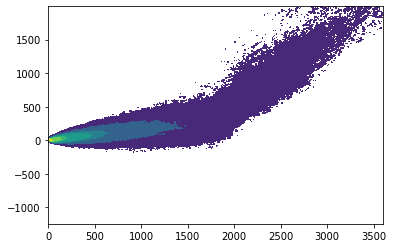

In [2]:
from hera import LSM
from unum.units import *
simulation = LSM.getSimulations(params__location="tiratCarmel")[0]
ConcentrationFortran = simulation.getConcentration(10*kg)

# Plotting the maximum concentration
cMax = ConcentrationFortran.max(dim="datetime").to_dataframe().reset_index()
cMax = cMax.loc[cMax.C>0]
plt.tricontourf(cMax.x,cMax.y,cMax.C,levels=[0.1,1,5,10,50,100,500,1000,1500,2000],norm=LogNorm())

## Getting the population

We load the population data in the area in which the simulation was done, using the name "tiratCarmel" we defined for the topography data.
The projectName deifned in the function that loads the data, projectPolygonOnPopulation, is the name of the project in which to search the area's name,
that may defer from the demography's project name.

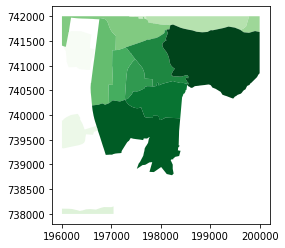

In [11]:
from hera.measurements.GIS.demography import datalayer as demoDatalayer

demography = demoDatalayer(projectName="Demography", databaseNameList=None, useAll=False,publicProjectName="Demography")
tiratCarmelDemography = demography.projectPolygonOnPopulation(Shape="tiratCarmel",projectName="Topography")
tiratCarmelDemography.plot(cmap="Greens")

## Choosing an agent

Agents can be loaded from the database or created using description dictionaries.
In order to demonstrate the needed structure of the descriptions,
we will use this example agent:

In [4]:
from hera import riskassessment as risk
from unum.units import *
description = {"agentConfig":{
    "effectParameters" : {
        "tenbergeCoefficient" : 1.5
    },
    "effects" : {
        "RegularPopulation":{
            "type": "Lognormal10",
            "calculator":{
                "TenBerge" : {"breathingRate":10*L/min}
            },
            "parameters":{
                "type": "Lognormal10DoseResponse",
                "levels":["Severe","Light"],
                "parameters":{
                "Severe": {
                    "TL_50" : 10,
                    "sigma": 0.5
                },
                "Light": {
                    "TL_50" : 1,
                    "sigma": 0.5
                }

            }
            }
        }
    }
}}
Agent = risk.AgentHome.getAgent(description)

The dimensions of the risk areas from the agent are calculated using the concentration.
Using the openFOAM run:

In [5]:
# cgroundmax = Concentration.loc[Concentration.height==5].reset_index().rename(columns={"time":"datetime","x":"y","y":"x","height":"z"}).set_index(["x","y","z","datetime"]).to_xarray()#.groupby(["x","y"]).max().compute().reset_index().set_index(["x","y","z","datetime"]).to_xarray()
# cgroundmax.attrs["Concentration"]=1*mg/m**3
# cgroundmax.attrs["dt"]=10*s
# riskAreas = Agent.RegularPopulation.calculate(cgroundmax, "Concentration", isel={"datetime":-1})
# riskAreas.set_geometry("ThresholdPolygon").plot()

Using the fortran run:

In [6]:
resampledC = ConcentrationFortran.resample(datetime="1Min").mean().compute().squeeze()
resampledC.attrs["C"]=1*mg/m**3
resampledC.attrs["dt"]=1*min
riskAreas = Agent.RegularPopulation.calculate(resampledC, "C", isel={"datetime":-1})#.reset_index()

The resample was done because of lack of memory, usually it is not needed.

## Projection on population

The last step before starting analizing the results is projecting the risk areas on the population polygons.
We have to choose the release coordinates and the wind direction.

In [7]:
releasePoint=[196400,740000]
mathematicalAngle=0
injuryareas = riskAreas.project(tiratCarmelDemography, loc=releasePoint,mathematical_angle=mathematicalAngle).reset_index()
injuryareas[:10]

/raid/opt/anaconda3/envs/Math-20-05/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,index,geometry,areaFraction,total_pop,effectedtotal_pop,percentEffected,ToxicLoad,severity,datetime
0,1516,"POLYGON ((196950.498 740261.607, 196950.663 74...",0.001482,3.203482,0.159746,0.049866,0.150513,Light,2016-01-01 13:00:00
1,1517,"MULTIPOLYGON (((197275.315 740358.174, 197275....",0.009297,39.436980,1.966573,0.049866,0.150513,Light,2016-01-01 13:00:00
2,1518,"MULTIPOLYGON (((197353.319 740354.080, 197344....",0.003941,7.689647,0.383454,0.049866,0.150513,Light,2016-01-01 13:00:00
3,1519,"MULTIPOLYGON (((198494.917 740641.515, 198489....",0.007416,36.330081,1.811644,0.049866,0.150513,Light,2016-01-01 13:00:00
4,1520,"MULTIPOLYGON (((198501.540 740493.011, 198498....",0.081335,305.818312,15.250006,0.049866,0.150513,Light,2016-01-01 13:00:00
5,1521,"MULTIPOLYGON (((196653.326 739929.896, 196652....",0.008322,20.971576,1.045773,0.049866,0.150513,Light,2016-01-01 13:00:00
6,1961,"MULTIPOLYGON (((198807.217 740599.829, 198797....",0.035498,124.756415,6.221132,0.049866,0.150513,Light,2016-01-01 13:00:00
7,1516,"POLYGON ((196950.663 740254.178, 196950.876 74...",0.000786,1.699135,0.169036,0.099484,0.228678,Light,2016-01-01 13:00:00
8,1517,"MULTIPOLYGON (((197277.208 740330.789, 197277....",0.003424,14.525743,1.445076,0.099484,0.228678,Light,2016-01-01 13:00:00
9,1518,"POLYGON ((197344.176 740343.687, 197335.687 74...",0.001772,3.456851,0.343901,0.099484,0.228678,Light,2016-01-01 13:00:00


## Presentation

The injuryareas parameter is a geodataframe with polygons that correspond to injury severities,
with the number of injured population in each polygon.
Using this data, one may design and present one's risk assessment as one desires.
For example, one may get the total number of injuries in each severity this way:

In [8]:
totalInjuries = injuryareas.groupby("severity")["effectedtotal_pop"].sum()
totalInjuries

severity
Light     1022.051795
Severe     136.665142
Name: effectedtotal_pop, dtype: float64

One may also use built-in plots of the riskassessment tool.
At the moment, one plot type is available,
which shows the risk areas polygons.

/raid/opt/anaconda3/envs/Math-20-05/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


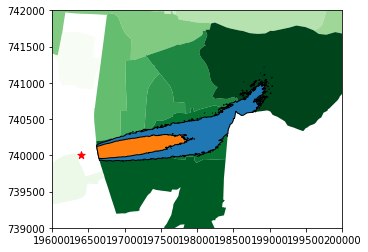

In [17]:
ax, retProj = risk.casualtiesPlots.plotCasualtiesProjection(results=riskAreas,area=tiratCarmelDemography,loc=releasePoint,
                                             mathematical_angle=mathematicalAngle, severityList=["Light","Severe"],
                                                            cycler=plt.cycler(fc=plt.rcParams['axes.prop_cycle'].by_key()['color'])*plt.cycler(ec=['black']))
ax.set_xlim(196000,200000)
ax.set_ylim(739000,742000)
ax.scatter(*releasePoint,marker="*",color="red",s=60)
tiratCarmelDemography.plot(ax=ax,cmap='Greens')
ax

In this plot, the red star is the release point, the freen areas are the different neighborhood in Tirat HaCarmel,
the blue area is the area in which there are light injuries, the orange area is the area
in which there are severe injuries.